In [2]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [1]:
def compute_epsilon_decay(epsilon, eps_decay=0.995, eps_min=0.1):
  epsilon *= eps_decay
  epsilon = max(eps_min, epsilon)
  return epsilon

# Q-learning

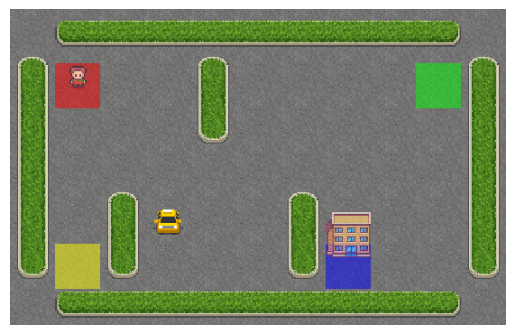

Action Space Discrete(6)
State Space Discrete(500)


In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.axis("off")
plt.show()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

In [10]:
MAX_EPISODE = 10000
ALPHA = 0.1
GAMMA = 0.6
q_table = np.zeros((env.observation_space.n, env.action_space.n))

epsilon = 1
rewards = []
for episode in range(1, MAX_EPISODE+1):
    
    if episode % 1000 == 0:
        print('Evaluating Episode: ', episode)
        
    state, _ = env.reset()
    done = False
    
    episode_reward = 0
    while not done:
        # ε-greedy policy
        if np.random.uniform() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        epsilon = compute_epsilon_decay(epsilon=epsilon)
        
        # Performing selected action
        new_state, reward, done, _, _ = env.step(action)

        # Q-learning update
        q_table[state][action] += ALPHA * (reward + GAMMA * np.max(q_table[new_state]) - q_table[state][action])

        episode_reward += reward
        state = new_state
        
    rewards.append(episode_reward)

Evaluating Episode:  1000
Evaluating Episode:  2000
Evaluating Episode:  3000
Evaluating Episode:  4000
Evaluating Episode:  5000
Evaluating Episode:  6000
Evaluating Episode:  7000
Evaluating Episode:  8000
Evaluating Episode:  9000
Evaluating Episode:  10000


Printe the q table

In [11]:
q_table[:5]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.39066201,  -2.34910247,  -2.39077128,  -2.35396979,
         -2.27325184, -10.57804815],
       [ -1.81234984,  -1.49171075,  -1.8545842 ,  -1.48692908,
         -0.7504    ,  -8.70324774],
       [ -2.32554962,  -2.25630241,  -2.34162805,  -2.25133497,
         -2.1220864 ,  -9.97511981],
       [ -2.49448265,  -2.49442003,  -2.4946189 ,  -2.49448337,
         -8.08949555,  -9.22183206]])

Plot reward values during episodes

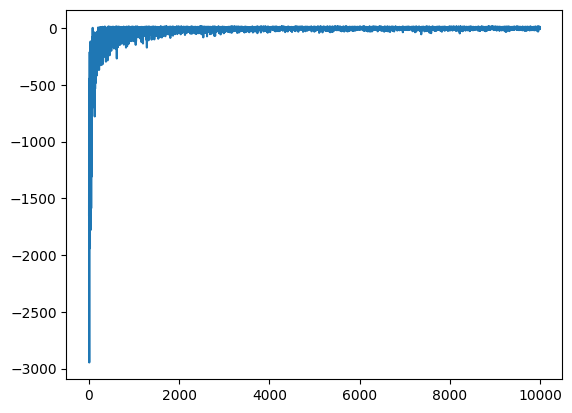

In [12]:
plt.plot(range(1, MAX_EPISODE+1), rewards)
plt.show()

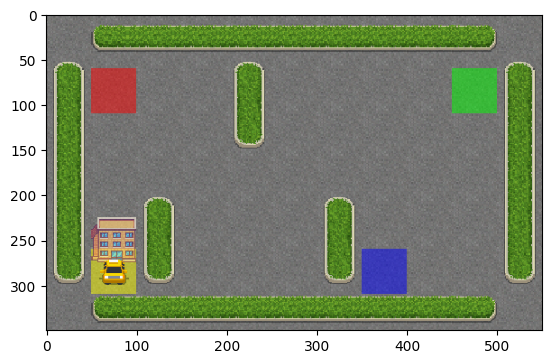

In [8]:
tot_penalities = 0
tot_steps = 0
for episode in range(5):
    
    state, _ = env.reset()
    done = False
    
    steps = 0
    while not done and steps < 30:
        plt.imshow(env.render())
        plt.show()
        sleep(.1)
        clear_output(wait=True)

        # Action selection
        action = np.argmax(q_table[state])
        
        # Performing selected action
        new_state, reward, done, _, _ = env.step(action)
        
        if reward == -10:
            tot_penalities += 1
            
        tot_steps += 1
        steps += 1
        
        state = new_state

# Deep Q-learning

## Cart pole

In [3]:
def create_dqn_model(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs =  layers.Dense(output_shape, activation='linear')(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [12]:
MAX_EPISODE = 1000
MAX_STEPS = 200
GAMMA = 0.9 # Discount factor for past rewards
BATCH_SIZE = 32
REPLAY_BUFFER_LEN = 2048 # Max length of replay buffer
COPY_STEP = 500

env = gym.make("CartPole-v1")

load_weights = False
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.01)
model = create_dqn_model(input_shape=env.observation_space.shape,
                         output_shape=env.action_space.n)
target_model = create_dqn_model(input_shape=env.observation_space.shape,
                            output_shape=env.action_space.n)
loss_function = keras.losses.Huber()

if load_weights:
    model.load_weights("../checkpoints/dqn_cartpole.h5")

steps_count = 0
epsilon = 1 # linear decay epsilon to encoruge exploration in early stage
running_reward = 0
total_rewards = deque(maxlen=MAX_EPISODE)
replay_buffer = deque(maxlen=REPLAY_BUFFER_LEN)
running_rewards = deque(maxlen=MAX_EPISODE)

for episode in range(1, MAX_EPISODE):
    state = np.array(env.reset()[0])
    episode_reward = 0
    
    # we only consider 200 steps length episode for faster computation
    for step in range(MAX_STEPS):
        steps_count += 1

        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action = tf.argmax(model(state_tensor, training=False)[0]).numpy()

        epsilon = compute_epsilon_decay(epsilon)

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.array(next_state)
        
        episode_reward += reward
        
        replay_buffer.append((state, action, reward, next_state, done))

        state = next_state

        if len(replay_buffer) >= 128:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            
            states = np.array([experience[0] for experience in batch])
            actions = [experience[1] for experience in batch]
            rewards = [experience[2] for experience in batch]
            next_states = np.array([experience[3] for experience in batch])
            dones = tf.convert_to_tensor(
                [float(experience[4]) for experience in batch]
            )
            
            future_rewards = target_model.predict(next_states, verbose=0)
            updated_q_values = rewards + GAMMA * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values * (1 - dones) - dones

            masks = tf.one_hot(actions, 2)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(states)
                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if steps_count % 25 == 0:
            # update the the target network with new weights
            target_model.set_weights(model.get_weights())

        if done:
            break
    
    total_rewards.append(episode_reward)
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
    running_rewards.append(running_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}: \trunning_reward={running_reward:.1f}")
 
    if running_reward >= 100:
        print(f"Solved in {episode+1} episodes!")
        break

print("Weight saved!")
model.save_weights("checkpoints/dqn_cartpole.h5")

Episode 10: 	running_reward=6.3
Episode 20: 	running_reward=12.0


KeyboardInterrupt: 

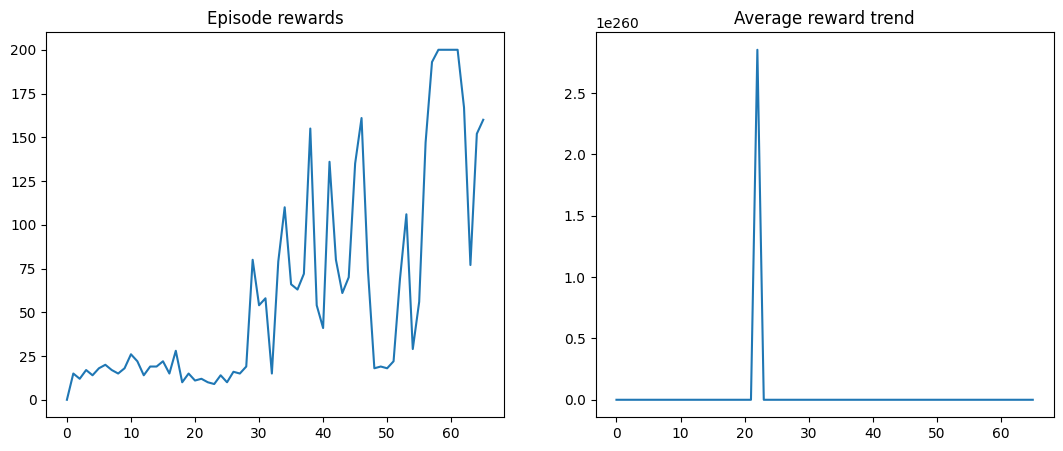

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
ax1.plot(total_rewards)
ax1.set_title("Episode rewards")
ax2.plot(running_rewards)
ax2.set_title("Running rewards")
plt.show()

Let's see how model perform after 100 episodes

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

state, _ = env.reset()
done = False
step_count = 0
max_steps = 1000
model = create_dqn_model(input_shape=env.observation_space.shape,
                            output_shape=env.action_space.n)
model.load_weights("checkpoints/dqn_cartpole.h5")
count_steps = 0
while step_count < max_steps:
    action = np.argmax(model.predict(state.reshape(1,4), verbose=0)[0])
    step_count += 1
    next_state, reward, done, _, _ = env.step(action)
    next_state = next_state.reshape(1,4)
    state = next_state
    count_steps += 1
    if done:
        print(f"End at {step_count} step")
        break
env.close()
print(count_steps)

## Atari

In [3]:
env = gym.make("ALE/Breakout-v5")
print("Observation space shape:", env.observation_space.shape)
print("Action space shape:", env.action_space.n)

Observation space shape: (210, 160, 3)
Action space shape: 4


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In this setup, we have to work with images, in particulare RGB 210x160 frame. Following the specification of Atari [paper](https://arxiv.org/pdf/1312.5602.pdf), I preproced it to obtain a grayscale 84x84 frames. In addiction, to make robust optimization, we optimize after 4 frames 

In [4]:
#Atari preprocessing wrapper
env = gym.wrappers.AtariPreprocessing(env, 
                                      noop_max=30, 
                                      frame_skip=1, 
                                      terminal_on_life_loss=False, 
                                      grayscale_obs=True, 
                                      grayscale_newaxis=False, 
                                      scale_obs=False)

#Frame stacking
env = gym.wrappers.FrameStack(env, 4)
print("Observation space shape:", env.observation_space.shape)

Observation space shape: (4, 84, 84)


create the dqn model like the one used in the paper

In [8]:
def atari_dqn_model(input_shape, out_shape):
    inputs = layers.Input(shape=input_shape)

    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(out_shape, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

input_shape=(84,84,4)
model = atari_dqn_model(input_shape, env.action_space.n)
target_model = atari_dqn_model(input_shape, env.action_space.n)

# Optimizer and Loss function
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.00025, clipnorm=1.0)
loss_function = keras.losses.Huber()

In [9]:
MAX_EPISODE = 1000
MAX_STEPS = 200
GAMMA = 0.99 # Discount factor for past rewards
BATCH_SIZE = 32
REPLAY_BUFFER_LEN = 100000 # Max length of replay buffer
COPY_STEP = 10000
LOAD_WEIGHTS = False


if LOAD_WEIGHTS:
    model.load_weights("../checkpoints/dqn_pong.h5")

steps_count = 0
epsilon = 1 # linear decay epsilon to encoruge exploration in early stage
running_reward = 0
total_rewards = deque(maxlen=MAX_EPISODE)
replay_buffer = deque(maxlen=REPLAY_BUFFER_LEN)
running_rewards = deque(maxlen=MAX_EPISODE)

for episode in range(1, MAX_EPISODE):
    state = np.array(env.reset()[0])
    state = np.transpose(state, [1,2,0])
    done = False
    episode_reward = 0
    
    # we only consider 200 steps length episode for faster computation
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action = tf.argmax(model(state_tensor, training=False)[0]).numpy()

        epsilon = compute_epsilon_decay(epsilon)

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.array(next_state)
        next_state = np.transpose(next_state, [1,2,0])
        
        episode_reward += reward
        
        replay_buffer.append((state, action, reward, next_state, done))

        state = next_state
        steps_count += 1

        if len(replay_buffer) >= BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            
            states = np.array([experience[0] for experience in batch])
            actions = [experience[1] for experience in batch]
            rewards = [experience[2] for experience in batch]
            next_states = np.array([experience[3] for experience in batch])
            dones = tf.convert_to_tensor(
                [float(experience[4]) for experience in batch]
            )
            
            future_rewards = target_model.predict(next_states, verbose=0)
            updated_q_values = rewards + GAMMA * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values * (1 - dones) - dones

            masks = tf.one_hot(actions, env.action_space.n)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(states)
                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)
                grads = tape.gradient(loss, model.trainable_variables)
            
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if steps_count % 25 == 0:
            # update the the target network with new weights
            target_model.set_weights(model.get_weights())
    
    total_rewards.append(episode_reward)
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
    running_rewards.append(running_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}: \trunning_reward={running_reward:.1f}")
 
    if running_reward >= 100:
        print(f"Solved in {episode+1} episodes!")
        break

print("Weight saved!")
model.save_weights("checkpoints/dqn_pong.h5")

KeyboardInterrupt: 